In [39]:
import os
import logging, os

logging.disable(logging.WARNING)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

In [40]:
from matplotlib import pyplot as plt
from musicnet.utils import Track, train_ids, notes_vocab, instruments_vocab, load_params
import librosa
import numpy as np
import tensorflow as tf
from tensorflow import keras
from glob import glob
from musicnet.model.Transformer import TransformerLRSchedule, WarmupLRSchedule
from sklearn.metrics import precision_score, recall_score, f1_score
from tensorflow.nn import weighted_cross_entropy_with_logits

In [41]:
tf.__version__

'2.17.0-rc1'

In [42]:
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [43]:
params = load_params(["train", "preprocess", "shared"])

In [44]:
id = train_ids()[-1]
track = Track(id)
x_chunks, y_chunks = track.preprocess(
    chunk_size_sec=params["chunk_size_sec"],
    chunk_shift_sec=params["chunk_shift_sec"],
    target_sr=params["target_sr"],
    note_rounding=params["note_rounding"],
    n_fft=params["n_fft"],
    hop_length=params["hop_length"],
    n_mels=params["n_mels"]
)

In [45]:
print(x_chunks.shape, y_chunks.shape)

(97, 998, 100) (97, 1000, 913)


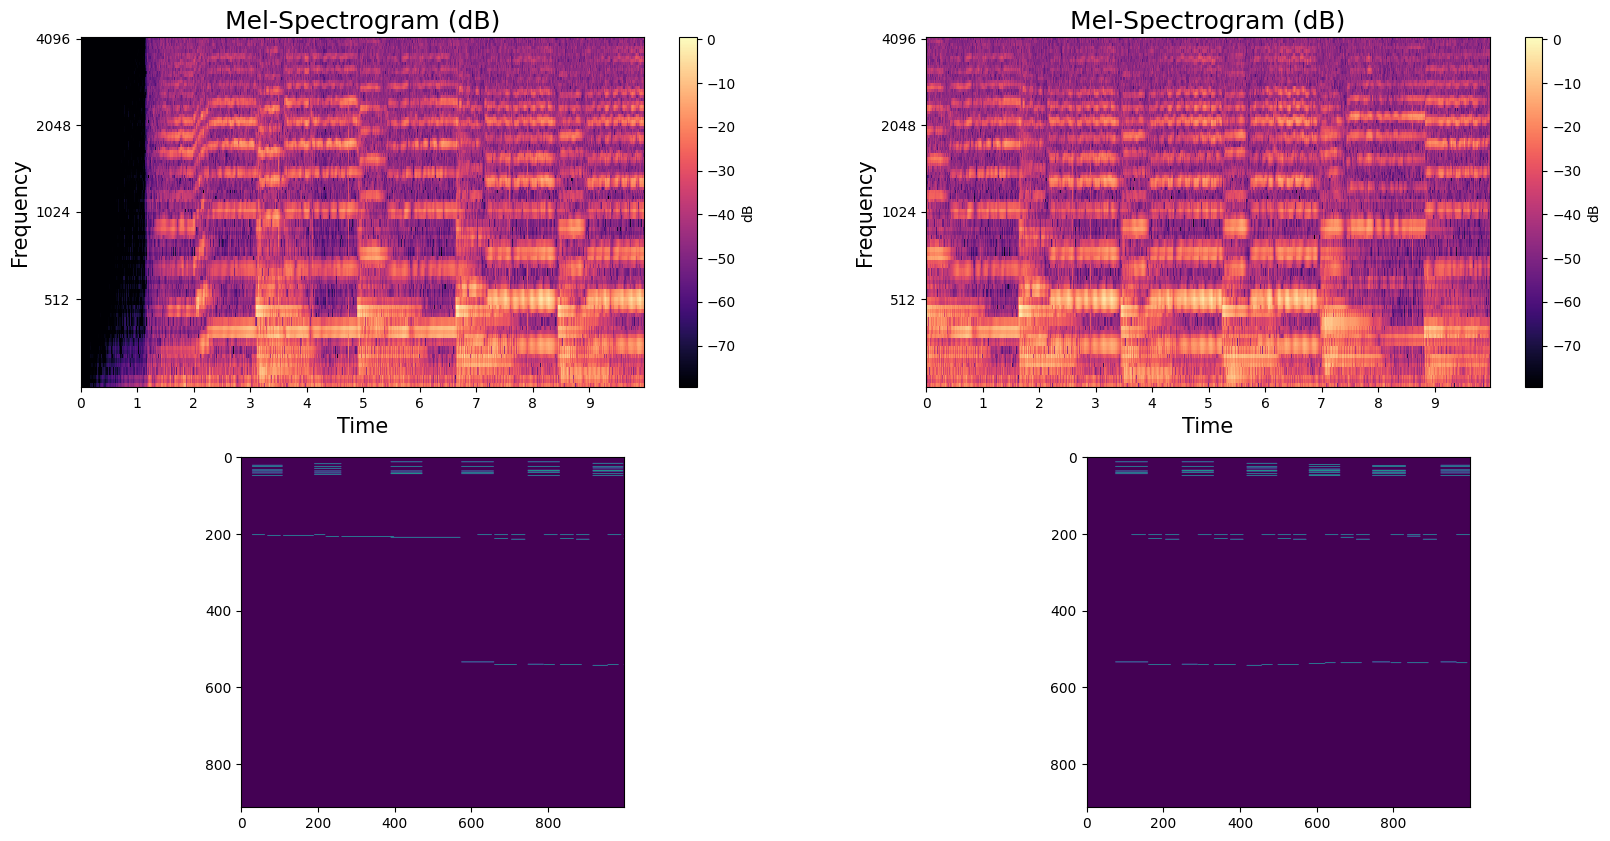

In [46]:
plt.figure(figsize=(20, 10))

for i in range(0, 2):
    plt.subplot(2, 2, i+1)
    librosa.display.specshow(
        x_chunks[i].T,
        sr=params["target_sr"],
        x_axis="time",
        y_axis="mel",
        hop_length=params["hop_length"],
        fmin=16,
        fmax=4096
    )
    plt.colorbar(label="dB")
    plt.title('Mel-Spectrogram (dB)', fontdict=dict(size=18))
    plt.xlabel('Time', fontdict=dict(size=15))
    plt.ylabel('Frequency', fontdict=dict(size=15))

for i in range(2, 4):
    plt.subplot(2, 2, i+1)
    plt.imshow(y_chunks[i].T)

In [30]:
y_pred = np.array([
    [ # First sequence
        [0.7, 0, 0, 0],
        [0.7, 0, 0.7, 0.7],
        [0, 0, 0, 0],
        [0, 0.7, 0, 0]
    ],
    [ # Second sequence
        [0.7, 0.7, 0.7, 0.7],
        [0, 0, 0, 0],
        [0.7, 0.7, 0.7, 0.7],
        [0, 0, 0, 0]
    ]
])

y_true = np.array([
    [ # First sequence
        [1, 0, 0, 0],
        [1, 1, 1, 0],
        [1, 0, 0, 0],
        [1, 1, 0, 1]
    ],
    [ # Second sequence
        [0, 1, 1, 1],
        [0, 0, 0, 1],
        [0, 0, 1, 1],
        [0, 0, 0, 1]
    ] 
])
f1 = keras.metrics.F1Score(threshold=0.5, average="macro")
f1.update_state(y_true.reshape(-1, 4), y_pred.reshape(-1, 4))

f1s = []
for c in range(0, 4):
    # Calculate precision, recall and f1 separately for each class:
    y_pred_c = y_pred[:, :, c].flatten()
    y_true_c = y_true[:, :, c].flatten()
    f1_c = f1_score(y_true_c, y_pred_c > 0.5)
    f1s.append(f1_c)
    print(c, {
        "precision":precision_score(y_true_c, y_pred_c > 0.5),
        "recall": recall_score(y_true_c, y_pred_c > 0.5),
        "f1": f1_c
    })

print("Final result: ", f1.result())
print("Avg f1:", np.mean(f1s))

0 {'precision': 0.5, 'recall': 0.5, 'f1': 0.5}
1 {'precision': 0.6666666666666666, 'recall': 0.6666666666666666, 'f1': 0.6666666666666666}
2 {'precision': 1.0, 'recall': 1.0, 'f1': 1.0}
3 {'precision': 0.6666666666666666, 'recall': 0.4, 'f1': 0.5}
Final result:  tf.Tensor(0.6666666, shape=(), dtype=float32)
Avg f1: 0.6666666666666666


In [48]:
inputs = np.array([
    [
        [10, 0.1],
        [20, 0.05],
        [40, 0.1],
        [20, 0.2],
        [10, 0.1]
    ],
    [
        [15, 0.05],
        [25, 0.03],
        [40, 0.1],
        [20, 0.2],
        [35, 0.15]
    ]
], dtype=np.float64)
bn = keras.layers.BatchNormalization(epsilon=1e-5)
print("Batch mean", inputs.reshape(-1, inputs.shape[-1]).mean(axis=0))
print("Batch std", inputs.reshape(-1, inputs.shape[-1]).std(axis=0))
print(
    "Numpy calc (batch dim flatten)",
    np.round((inputs - inputs.reshape(-1, inputs.shape[-1]).mean(axis=0)) / inputs.reshape(-1, inputs.shape[-1]).std(axis=0), 2)
)
print(
    "BatchNorm layer",
    np.round(bn(inputs, training=True).numpy(), 2)
)
print(bn.weights[0].value)
print(bn.weights[1].value)
print(bn.weights[2].value)
print(bn.weights[3].value)

Batch mean [23.5    0.108]
Batch std [10.73545528  0.05635601]
Numpy calc (batch dim flatten) [[[-1.26 -0.14]
  [-0.33 -1.03]
  [ 1.54 -0.14]
  [-0.33  1.63]
  [-1.26 -0.14]]

 [[-0.79 -1.03]
  [ 0.14 -1.38]
  [ 1.54 -0.14]
  [-0.33  1.63]
  [ 1.07  0.75]]]
BatchNorm layer [[[-1.26 -0.14]
  [-0.33 -1.03]
  [ 1.54 -0.14]
  [-0.33  1.63]
  [-1.26 -0.14]]

 [[-0.79 -1.03]
  [ 0.14 -1.38]
  [ 1.54 -0.14]
  [-0.33  1.63]
  [ 1.07  0.74]]]
<tf.Variable 'batch_normalization_45/gamma:0' shape=(2,) dtype=float32, numpy=array([1., 1.], dtype=float32)>
<tf.Variable 'batch_normalization_45/beta:0' shape=(2,) dtype=float32, numpy=array([0., 0.], dtype=float32)>
<tf.Variable 'batch_normalization_45/moving_mean:0' shape=(2,) dtype=float32, numpy=array([0.235  , 0.00108], dtype=float32)>
<tf.Variable 'batch_normalization_45/moving_variance:0' shape=(2,) dtype=float32, numpy=array([2.1425   , 0.9900318], dtype=float32)>


Text(0.5, 0, 'Train Step')

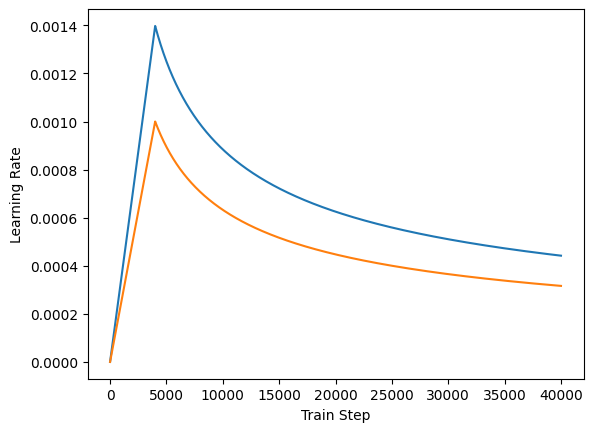

: 

In [ ]:
transformer_lr_schedule = TransformerLRSchedule(128, 4000)
warmup_lr_schedule = WarmupLRSchedule(0.0002, 4000)
plt.plot(transformer_lr_schedule(tf.range(40000, dtype=tf.float32)), label="TransformerLRSchedule")
plt.plot(warmup_lr_schedule(tf.range(40000, dtype=tf.float32)), label="WarmupLRSchedule")
plt.ylabel('Learning Rate')
plt.xlabel('Train Step')